# Deep Deterministic Policy Gradient (DDPG)

The approaches introduced in the previous sections are limited only to discret action space domains. Finding the greedy-policy in a continuous action space requires an optimization of the action at at every time step $t$, which siginifcantly increased the computationaly time of learning an gets impossible in high dimensional action spaces. However, this may also result in neglecting essential information about the action space structure, affecting the quality of the results.
The Deterministic Policy Gradient (DPG) [Silver et al. (2014)] utilizes an A

Lillicrap et al. (2016) introduced the Deep Deterministic Policy Gradient (DDPG) which utilizes ctor-Critic architecture ato be abblicable in  continuous action spaces. Like within the Deterministic Policy Gradient (DPG) [Silver et al. (2014)], the actor is reprsented by a neural network that directly maps states to actions, i.e., the output is equal to the executed action instead of outputting the probability distribution across a discrete action space. Instead of using Q-Learning as critic, like in DPG, the DQN approache is applied.

The whole pseudo code of the DDPG algorithm looks like this:

![image-2.png](attachment:image-2.png)


## Actor and Critic

First, lets define the architecture of the actor and critci network by using again pyorch.

In [2]:
!pip install gym==0.21.0
!pip install gym[toy_text]==0.21.0
!pip install gym[classic_control]==0.21.0
!pip install tqdm
!pip install torch torchvision torchaudio
!pip install numpy==1.24.1
!pip install pyglet==1.5.27

  Using cached gym-0.21.0.tar.gz (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package m

In [8]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable

# Initalize weigths for the neurnal network
WEIGHTS_FINAL_INIT = 3e-3
BIAS_FINAL_INIT = 3e-4


def fan_in_uniform_init(tensor, fan_in=None):
    """
    Utility function for initializing weigths for actor and critic
    """
    if fan_in is None:
        fan_in = tensor.size(-1)

    w = 1. / np.sqrt(fan_in)
    nn.init.uniform_(tensor, -w, w)


class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, action_dim=1):
        super(Critic, self).__init__()

        self.action_dim = action_dim

        # Standard Settings
        self.linear1 = nn.Linear(input_size, hidden_size[0])
        self.linear2 = nn.Linear(hidden_size[0] + self.action_dim, hidden_size[1])
        self.linear3 = nn.Linear(hidden_size[1], output_size)

        # Weight Init
        fan_in_uniform_init(self.linear1.weight)
        fan_in_uniform_init(self.linear1.bias)

        fan_in_uniform_init(self.linear2.weight)
        fan_in_uniform_init(self.linear2.bias)

        # Final weigths distribution is predfeined
        nn.init.uniform_(self.linear3.weight, -WEIGHTS_FINAL_INIT, WEIGHTS_FINAL_INIT)
        nn.init.uniform_(self.linear3.bias, -BIAS_FINAL_INIT, BIAS_FINAL_INIT)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = state

        # Layer 1
        x = F.relu(self.linear1(x))
        # Layer 2
        x = torch.cat((x, action), 1) # actions are added as input for the seconed layer of the critic
        x = F.relu(self.linear2(x))
        # Layer 3
        x = self.linear3(x)

        return x


class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=3e-4):
        super(Actor, self).__init__()

        # define layers of the network
        self.linear1 = nn.Linear(input_size, hidden_size[0])
        self.linear2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear3 = nn.Linear(hidden_size[1], output_size)

        # Weight Init
        fan_in_uniform_init(self.linear1.weight)
        fan_in_uniform_init(self.linear1.bias)

        fan_in_uniform_init(self.linear2.weight)
        fan_in_uniform_init(self.linear2.bias)

        # Final weigths distribution is predfeined
        nn.init.uniform_(self.linear3.weight, -WEIGHTS_FINAL_INIT, WEIGHTS_FINAL_INIT)
        nn.init.uniform_(self.linear3.bias, -BIAS_FINAL_INIT, BIAS_FINAL_INIT)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = state

        # Layer 1
        x = F.relu(self.linear1(x))
        # Layer 2
        x = F.relu(self.linear2(x))
        # Layer 3
        x = torch.tanh(self.linear3(x))  # from -1 to 1 (eventually as alternative to rescaling)

        return x

## Memory

As with DQN, DDPG makes use of a memory buffer from which a mini-batch is sampled at each time step for updating both, actor and critic. During each trajectory roll-out, we save all the experience tuples (state, action, reward, next_state) and store them in a finite-sized cache — the “memory buffer” from which the mini-batch gets randomly sampled. Why do we use experience replay? In optimization asks, we want the data to be independently distributed. This fails to be the case when we optimize a sequential decision process in an on-policy way, because the data then would not be independent of each other. When we store them in a replay buffer and take random batches for training, we overcome this issue.

## Noise

In contrast to DQN, within Actor-Critic methods explorations can’t be accomplished through an $greedy-policy$. In a continuous action space exploration can be performed by simply adding noise directly, sampled from a noise process $N$ , to actions themselves.

Noise formel

Lillicrap et al. (2016) originally used an Ornstein-Uhlenbeck noise (Uhlenbeck and Ornstein,1930), but recent research showed that using a normal distributed Gaussain noise leads to the same outcome.


In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque


class GaussianNoise(object):
    def __init__(self, action_space, mu=0.0, sigma=0.1, regulation_coef=1, decay_rate=0):

        self.action_dim = action_space.shape[0]
        self.low = action_space.low
        self.high = action_space.high
        self.distance = abs(self.low - self.high)

        self.decay_rate = decay_rate
        self.regulation_coef = regulation_coef
        self.mu = mu
        self.sigma = sigma

        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def get_action(self, action, step=0):

        noise_list = (np.random.normal(self.mu, self.sigma, self.action_dim)
                      * ((1 - self.decay_rate) ** step) * self.regulation_coef)

        if any(x < 0.01 for x in ((noise_list) ** 2) ** 0.5):
            noise_list = np.random.normal(0, 0.01, self.action_dim)

        noisy_action = np.clip(action + noise_list, self.low, self.high)

        return noisy_action

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

## Update Process:
The actor takes the state as input and directly ouputs the action $a_t = μ(s_t | θ^{μ}_{t})$. The critic then takes the
state and the output of the actor, i.e. the action, as input and calculates a Q-value, which is used to calculate the loss of the actor. To avoid interdependencies when calculating the loss of the actor $μ(s | θ_μ)$ and critic $Q(s, a | θ_Q)$ it is necessary to define target functions. The targets are time-delayed copies of their original networks that solowly track the learned networks.

Described mathimaticall, the update process looks like the following:

First, the loss of the critic gets caluclated by:

\begin{align}
L = \frac{1}{N} \sum_i (y_i - Q(s_i,a_i)| θ^{Q}))^2
\end{align}

with:

\begin{align}
y_i = r_i + γQ′(s_{i+1}, μ′(s_{i+1} | θ^{μ′}) | θ^{Q′}
\end{align}

Than the actor policy is updated by calculating:
\begin{align}
∇_{θ^μ} J ≈ \frac{1}{N} \sum_i ∇_a Q(s,a)| θ^{Q})|_{s=s_i,a=μ(s_i)}∇_{θ^μ}μ(s| θ^μ) | s_i
\end{align}

Finally, the target networks are updated by:

\begin{align}
θ^{Q′} ←− τθ^Q + (1 − τ )θ^{Q′}
\end{align}
and
\begin{align}
θ^{μ′} ←− τθ^μ + (1 − τ )θ^{μ′}
\end{align}


In [10]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class DDPG:
    def __init__(self, env, hidden_size=(400, 300), actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99,
                 tau=1e-3, max_memory_size=50000):

        # BiddingMarket_energy_Environment Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]

        # DDPG specific Params
        self.gamma = gamma
        self.tau = tau
        self.hidden_size = hidden_size
        self.output_size = 1  # only for critic

        # Networks
        self.actor = Actor(self.num_states, self.hidden_size, self.num_actions).to(device)
        self.actor_target = Actor(self.num_states, self.hidden_size, self.num_actions).to(device)
        self.critic = Critic(self.num_states, self.hidden_size, self.output_size, self.num_actions).to(device)
        self.critic_target = Critic(self.num_states, self.hidden_size, self.output_size, self.num_actions).to(device)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion = nn.MSELoss()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0).to(device))
        self.actor.eval()
        action = self.actor.forward(state)
        self.actor.train()
        # action = action.detach().numpy()[0,:]
        action = action.detach().cpu().numpy()[0, :]
        return action

    def update(self, batch_size):

        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)

        states = torch.FloatTensor(np.asarray(states), device=device)
        actions = torch.FloatTensor(np.asarray(actions), device=device)
        rewards = torch.FloatTensor(np.asarray(rewards), device=device)
        next_states = torch.FloatTensor(np.asarray(next_states), device=device)
        # done = torch.FloatTensor(np.asarray(done), device=device)

        # Critic loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q

        # update networks
        self.critic_optimizer.zero_grad()
        # Critic loss
        critic_loss = self.critic_criterion(Qvals, Qprime)
        critic_loss.backward()
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        policy_loss.backward()
        self.actor_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

### Define function to visualize the results

In [11]:
%matplotlib inline
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import pyglet

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Train

In [ ]:
from IPython.display import clear_output
from time import sleep
import matplotlib
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print(f"Episode: {frame['episode']}")
        sleep(.1)

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

###Mountain Car Continuous Environment
The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gym: one with discrete actions and one with continuous. This version is the one with continuous actions.

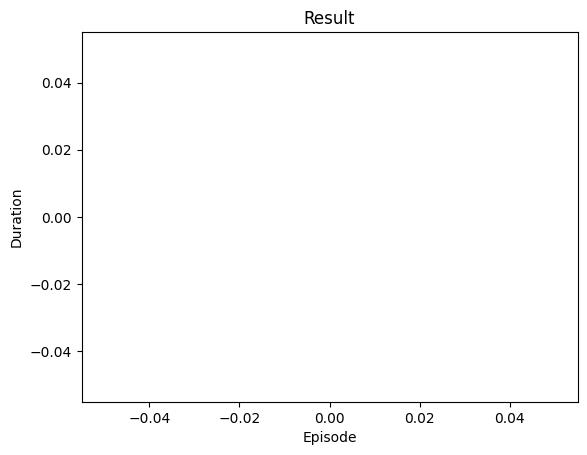

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [32]:

import gym

# Intialize again the environment from gym
env = gym.make('MountainCarContinuous-v0')


RENDER = True

#####################  hyper parameters  ####################

MAX_EPISODES = 1000
MAX_EP_STEPS =2500

# DDPG
BATCH_SIZE = 128
ACTOR_LR =1e-4
CRITIC_LR = 1e-3
GAMMA = 0.99
TAU = 1e-3
MAX_MEMORY_SIZE = 50000

# Noise
REGULATION_COEFFICENT = 10 # only moves the variance (if =1: sigma stays the same)
DECAY_RATE = 0.001
NOISE_VARIANCE = 0.1

# Initalize ddpg agent
ddpg = DDPG(env, hidden_size=[256, 128], actor_learning_rate=ACTOR_LR, critic_learning_rate=CRITIC_LR, gamma=GAMMA,
            tau=TAU, max_memory_size=MAX_MEMORY_SIZE)

# Random Guassian Noise gets added to the actions for exploratation
noise = GaussianNoise(env.action_space, mu=0, sigma=NOISE_VARIANCE,
                      regulation_coef=REGULATION_COEFFICENT, decay_rate=DECAY_RATE)

# Training process
noise.reset()
frames = []

episode_durations = []
for i in range(MAX_EPISODES):
    state = env.reset().astype('float64').T
    ep_reward = 0
    while done != True:

        # Add exploration noise
        action = ddpg.get_action(state)
        action = noise.get_action(action)

        next_state, reward, done, _ = env.step(action)

        #Saves the played round as tuple in the memory
        ddpg.memory.push(state, action, reward, next_state.astype('float64').T, done)


        if len(ddpg.memory) > BATCH_SIZE:
            ddpg.update(BATCH_SIZE)

        state = next_state.astype('float64').T
        ep_reward += reward

        if RENDER:
            frames.append(env.render(mode='rgb_array'))
            episode_durations.append(j + 1)
            plot_durations() # doesnt look that appealing here ;)


plot_durations(show_result=True)
plt.ioff()
plt.show()

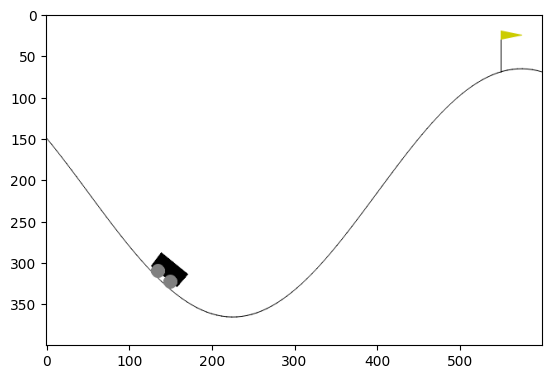

In [31]:
for frame in frames:
    clear_output(wait=True)
    plt.imshow(frame)
    plt.show()

## Test

In [ ]:
MAX_EPISODES = 500
MAX_EP_STEPS =25

RENDER = True
plt.ion()

for i in range(MAX_EPISODES):
    state = env.reset().astype('float64').T
    ep_reward = 0
    for j in range(MAX_EP_STEPS):

        # Add exploration noise
        action = ddpg.get_action(state)
        action = noise.get_action(action)

        next_state, reward, done, _ = env.step(action[0],i)

        state = next_state.astype('float64').T
        ep_reward += reward

        if RENDER:
            env.render(mode='rgb_array')

        if done:
            episode_durations.append(j + 1)
            plot_durations()
            break

plot_durations(show_result=True)
plt.ioff()
plt.show()